# Indian Liver Patient Records

Use supervised learning on the Indian patient records to determine which patients have liver disease. The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)

## Outline <a id='outline'></a>

1. [Exploring data](#Exploringdata): 
     - Find missing data, and turn string data into catergory
     - Inspect the number of patients with and without liver disease among [age and gender groups](#genderage)
    
2. [Logistic Regression](#LG): 
     - [Hyperparameter tuning](#LG_hyper)
     - [Feature of importance](#LG_feature)
     - [Results](#LG_result): confusion matrix, most correct and most incorrect predictions for each class
     
3. [Conclusions](#con): 

In [1]:
#import packages
import sys
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')
#sys.path.append(r'C:\Users\Benny\Anaconda3\envs\fastai\Lib\site-packages\graphviz')

%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss)

from IPython.display import display
import seaborn as sns
plt.style.use('ggplot')

import feather

## Exploring data <a id='Exploringdata'></a>

The data exploration were done previous [the random forest notebook](#https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb)

In [2]:
df_raw=pd.read_feather('tmp/liver_patient_raw')

In [3]:
df_raw.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,ill
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,ill
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,ill
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,ill
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,ill


In [4]:
df, y, nas, mapper = proc_df(df_raw,y_fld='Dataset', do_scale=True)

In [5]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

In [6]:
x_trn = df[~mask]
x_val = df[mask]
y_trn = y[~mask]
y_val = y[mask]

In [7]:
_, nunique_trn = np.unique(y_trn, return_counts=True)
_, nunique_val = np.unique(y_val, return_counts=True)

print(f'Training data has {nunique_trn[1]/nunique_trn.sum()} ill patients')
print(f'Validataion data has {nunique_val[1]/nunique_val.sum()} ill patients')

Training data has 0.7100456621004566 ill patients
Validataion data has 0.7241379310344828 ill patients


In [8]:
#define score report function for RF and LG
def print_score(m):
    y_trn_prob = m.predict_proba(x_trn)
    y_val_prob = m.predict_proba(x_val)
    res = [log_loss(y_trn, y_trn_prob), log_loss(y_val, y_val_prob),
          m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('train loss\t val loss \t train accuracy \t val accuracy')
    print(res)

## Logistic Regression <a id='LR'></a>

In [9]:
#baseline LG
mlg = LogisticRegression()
mlg.fit(x_trn, y_trn)
print_score(mlg)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train loss	 val loss 	 train accuracy 	 val accuracy
[0.502356115770469, 0.473860615793937, 0.728310502283105, 0.7724137931034483]


In [10]:
mlg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

### Hyperparameters tuning <a id='LG_hyper'></a>

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [12]:
param_dist = {'dual': [False],
              'max_iter': [100,110,120,130,140],
              'C':[1.0,1.5,2.0,2.5],
              'penalty':['l1','l2']}

In [13]:
#n_iter_search = 100
grid_search = GridSearchCV(mlg, param_grid=param_dist, cv=5, n_jobs=-1)

In [14]:
grid_search.fit(x_trn, y_trn)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'dual': [False], 'max_iter': [100, 110, 120, 130, 140], 'C': [1.0, 1.5, 2.0, 2.5], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
grid_search.best_score_, grid_search.best_params_

(0.7100456621004566,
 {'C': 1.0, 'dual': False, 'max_iter': 100, 'penalty': 'l1'})

In [16]:
mlg = LogisticRegression(dual=False, penalty='l1', max_iter=100, C=1.0, solver='liblinear')
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5024864339788435, 0.4754750405576368, 0.7191780821917808, 0.7793103448275862]


### LG Feature of importance <a id='LG_feature'></a>

Feature of importance in logistic region can be accessed by a .coef_ attribute. 

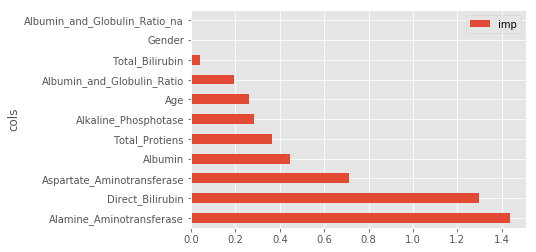

In [17]:
fi_lg = pd.DataFrame({'cols': x_trn.columns, 'imp':np.abs(mlg.coef_[0])})
fi_lg = fi_lg.sort_values('imp', ascending=False)
fi_lg.plot('cols','imp',kind='barh')

Similar feature of importance as what was observed by the [random forest model](#https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb). Compare this with a custom permulation-based feature of importance function.

In [18]:
to_keep_lg = fi_lg[fi_lg.imp>0.05].cols
print(to_keep_lg)

5      Alamine_Aminotransferase
3              Direct_Bilirubin
6    Aspartate_Aminotransferase
8                       Albumin
7                Total_Protiens
4          Alkaline_Phosphotase
0                           Age
9    Albumin_and_Globulin_Ratio
Name: cols, dtype: object


In [19]:
# custom made feature of importance
def feat_importance(m, x_trn, y_trn, metric=accuracy_score):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append((baseline - shuffle_score)/baseline*100)
        imp.append(np.maximum(0,np.mean(shuffle)))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

In [20]:
# use fastai command to calculate feature of importance
fi_per = feat_importance(mlg, x_trn, y_trn, accuracy_score)
fi_per

,cols,imp,imp_std
7,Total_Protiens,3.873016,1.903703
0,Age,2.126984,1.354704
9,Albumin_and_Globulin_Ratio,2.031746,0.964996
8,Albumin,1.523810,2.203092
3,Direct_Bilirubin,0.571429,0.662877
4,Alkaline_Phosphotase,0.190476,0.780204
1,Gender,0.000000,0.000000
2,Total_Bilirubin,0.000000,0.444444
5,Alamine_Aminotransferase,0.000000,0.743833
6,Aspartate_Aminotransferase,0.000000,0.815570


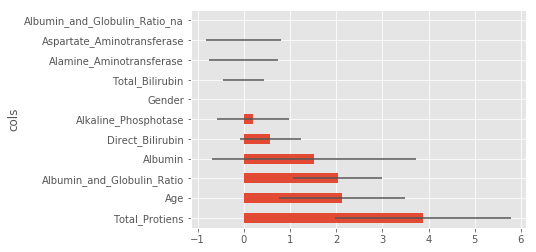

In [21]:
fi_per.plot('cols', 'imp', 'barh', xerr='imp_std', legend=False)

The permuatation-based feature of importance gives more aggressive feature drop. 

In [27]:
to_keep_per = fi_per[fi_per.imp>0.05].cols
print(to_keep_per)

7                Total_Protiens
0                           Age
9    Albumin_and_Globulin_Ratio
8                       Albumin
3              Direct_Bilirubin
4          Alkaline_Phosphotase
Name: cols, dtype: object


Compare the performance of the models with the features described by lg.coef_ and permulted feature of importance

In [31]:
df_keep = df[to_keep_lg].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]

In [32]:
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5025028233922382, 0.4754700752199781, 0.7214611872146118, 0.7793103448275862]


In [28]:
df_keep = df[to_keep_per].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]

In [29]:
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.522651782662451, 0.5038302929497018, 0.7100456621004566, 0.7379310344827587]


Using coef_ actually give better result. We will look at features which are related and see if droping one of those could improve the model. 

Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [33]:
df_keep = df[to_keep_lg].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]
mlg.fit(x_trn, y_trn)
mlg.score(x_trn, y_trn)

0.7214611872146118

In [40]:
x_trn.columns

Index(['Alamine_Aminotransferase', 'Direct_Bilirubin',
       'Aspartate_Aminotransferase', 'Albumin', 'Total_Protiens',
       'Alkaline_Phosphotase', 'Age', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [43]:
def get_oob(df_keep):
    
    mlg.fit(x_trn, y_trn)
    return mlg.score(x_trn, y_trn), mlg.score(x_val, y_val)

In [44]:
for drop_fea in ('Albumin', 'Total_Protiens', 
                 'Aspartate_Aminotransferase', 'Alamine_Aminotransferase'):
    print(drop_fea, get_oob(x_trn.drop(drop_fea, axis=1)))

Albumin (0.7214611872146118, 0.7793103448275862)
Total_Protiens (0.7214611872146118, 0.7793103448275862)
Aspartate_Aminotransferase (0.7214611872146118, 0.7793103448275862)
Alamine_Aminotransferase (0.7214611872146118, 0.7793103448275862)


### Analyzing LG Results <a id='LG_result'></a>

In [45]:
y_preds = mlg.predict(x_val)
y__proba = mlg.predict_proba(x_val)

Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.75      0.30      0.43        40
         Ill       0.78      0.96      0.86       105

   micro avg       0.78      0.78      0.78       145
   macro avg       0.77      0.63      0.65       145
weighted avg       0.77      0.78      0.74       145



([<matplotlib.axis.YTick at 0x2c5ae2a4160>,
 <a list of 2 Text yticklabel objects>)

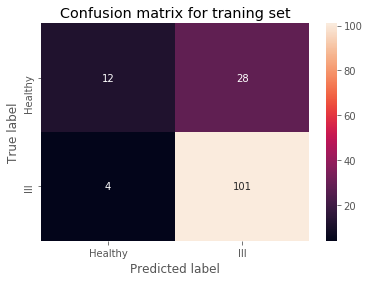

In [46]:
#print('Confusion Matrix: \n', confusion_matrix(y_val,preds))
print('Classification Report validation set: \n', classification_report(y_val,y_preds, 
                                                        target_names=['Healthy', 'Ill']))

sns.heatmap(confusion_matrix(y_val,y_preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for traning set')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_preds)

0.630952380952381

## Conclusions <a id='con'></a>

Logistic regression achieved 77% accuracy on the validation set (less over fittign compared to random forest) Features included in the models are 'Alamine_Aminotransferase', 'Direct_Bilirubin', 'Aspartate_Aminotransferase', 'Albumin', 'Total_Protiens','Alkaline_Phosphotase', 'Age','Albumin_and_Globulin_Ratio'. The logistic regression and random forest has large false positive.

In the future, I will use neural network for this task and compare the results.